In [5]:
# temporary environment setup on GOOGLE COLAB

# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
# !tar xf spark-2.4.7-bin-hadoop2.7.tgz
# # !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
# import findspark
# findspark.init()
# from google.colab import files

# dataset setup

# !wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
# !wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
#  import datetime
#  today = datetime.date.today()
#  first = today.replace(day=1)
#  lastMonth = first - datetime.timedelta(days=1)
#  print(lastMonth.strftime("%Y-%m-%d"))

In [2]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

22/01/01 20:27:37 WARN Utils: Your hostname, Legion resolves to a loopback address: 127.0.1.1; using 172.27.97.16 instead (on interface eth0)
22/01/01 20:27:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/01 20:27:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [9]:
feature = sc.read.csv("/home/iron/Documents/1.Learning/features.csv",
                      inferSchema=True,
                      header=True)
label = sc.read.csv("/home/iron/Documents/1.Learning/labels.csv",
                    inferSchema=True,
                    header=True)

In [10]:
print(feature.count())
print(label.count())
print(feature.columns)
print(label.columns)

59400
59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
['id', 'status_group']


In [11]:
data = feature.join(label, on=("id"))
print("Count - " + str(data.count()))

Count - 59400


In [12]:
print(data.printSchema())


print(data.show(10))

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable = 

21/12/18 16:47:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+----------+-------------+-------------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+---------------+---------+-----------+-------------+---------------+----------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+--------------+
|   id|amount_tsh|date_recorded|             funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|     subvillage|   region|region_code|district_code|            lga|      ward|population|public_meeting|         recorded_by|scheme_management|         scheme_name|permit|construction_year|extraction_type|extracti

In [13]:
# This is closer to pandas df.head()
data = data.withColumn('region_code',
                       col('region_code').cast(StringType())).withColumn(
                           'district_code',
                           col('district_code').cast(StringType()))

In [14]:
print(data.printSchema())

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: string (nullable = true)
 |-- district_code: string (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable = tr

In [15]:
#drop duplicate ID
data = data.dropDuplicates(["id"])


In [16]:
# removing timestamps having null values

null_count_threh = data.select([(count(when(isnan(c) | col(c).isNull(), c ))/data.count()).alias(c) for c in data.columns if c not in {"date_recorded", "public_meeting", "permit"}]).collect()

In [17]:
agg_dict_list = [row.asDict() for row in null_count_threh]
agg_dict = agg_dict_list[0]
# print(agg_dict)

In [18]:
col_null = list({i for i in agg_dict if agg_dict[i] > 0.4})
print("Null cols greater that 40 percent => ", col_null)

print("\n",agg_dict)

Null cols greater that 40 percent =>  ['scheme_name']

 {'id': 0.0, 'amount_tsh': 0.0, 'funder': 0.0611952861952862, 'gps_height': 0.0, 'installer': 0.061531986531986535, 'longitude': 0.0, 'latitude': 0.0, 'wpt_name': 0.0, 'num_private': 0.0, 'basin': 0.0, 'subvillage': 0.0062457912457912455, 'region': 0.0, 'region_code': 0.0, 'district_code': 0.0, 'lga': 0.0, 'ward': 0.0, 'population': 0.0, 'recorded_by': 0.0, 'scheme_management': 0.06526936026936027, 'scheme_name': 0.4741750841750842, 'construction_year': 0.0, 'extraction_type': 0.0, 'extraction_type_group': 0.0, 'extraction_type_class': 0.0, 'management': 0.0, 'management_group': 0.0, 'payment': 0.0, 'payment_type': 0.0, 'water_quality': 0.0, 'quality_group': 0.0, 'quantity': 0.0, 'quantity_group': 0.0, 'source': 0.0, 'source_type': 0.0, 'source_class': 0.0, 'waterpoint_type': 0.0, 'waterpoint_type_group': 0.0, 'status_group': 0.0}


In [19]:
data.groupBy('recorded_by').count().show()

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



In [20]:
data.groupBy('water_quality').count().orderBy('count', ascending=False).show()

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



In [21]:
data = data.drop('recorded_by')

In [22]:
data.groupBy('status_group').pivot('region').sum('amount_tsh').toPandas().to_csv("/home/iron/test.csv")



In [26]:
str_cols = [ item[0] for item in data.dtypes if item[1].startswith('string') ]
for cols in str_cols:
    data = data.withColumn(cols, trim(data[cols]))

print(str_cols)

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [25]:

for column in str_cols[:2]:
    print(data.groupBy(column).count().orderBy('count', ascending=False).show())
    value_cat = data.groupBy(column).count().collect()

    # print(value_cat)
    lessthan = [x[0] for x in value_cat if x[1]<1000]
    data = data.withColumn(column, when(col(column).isin(lessthan), 'others').otherwise(col(column)))
    data.groupBy(column).count().orderBy('count', ascending=False).show()

+-------------+-----+
|date_recorded|count|
+-------------+-----+
|       others|59400|
+-------------+-----+

None
[Row(date_recorded='others', count=59400)]
+-------------+-----+
|date_recorded|count|
+-------------+-----+
|       others|59400|
+-------------+-----+

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|              others|35052|
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|              Unicef| 1057|
+--------------------+-----+

None
[Row(funder=None, count=3635), Row(funder='Rwssp', count=1374), Row(funder='Unicef', count=1057), Row(funder='Danida', count=3114), Row(funder='others', count=35052), Row(funder='Government Of Tanzania', count=9084), Row(funder='Kkkt', count=1287), Row(funder='Hesawa', count=2202), Row(funder='World Bank', count=1349

imputing missing values

In [29]:
# population|count|
# +----------+-----+
# |         0|21381|
# |         1| 7025|


data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
+----------+-----+
only showing top 20 rows



In [31]:
data = data.withColumn('population', when(col('population') < 2, lit(None)).otherwise(col('population')))
w = Window.partitionBy(data['district_code'])
data = data.withColumn('population', when(col('population').isNull(), avg(data['population']).over(w)).otherwise(col('population')))

data = data.withColumn('population', ceil(data['population']))
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|      null|   35|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
+----------+-----+
only showing top 20 rows



In [32]:
# visualisation
color_status = {'functional': 'green', 'non functional': 'red', 'functional needs repair': 'blue'}

In [34]:
cols = ['status_group', 'payment_type', 'longitude', 'latitude', 'gps_height']
df = data.select(cols).toPandas()

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'never pay'),
  Text(1, 0, 'annually'),
  Text(2, 0, 'monthly'),
  Text(3, 0, 'on failure'),
  Text(4, 0, 'unknown'),
  Text(5, 0, 'per bucket'),
  Text(6, 0, 'other')])

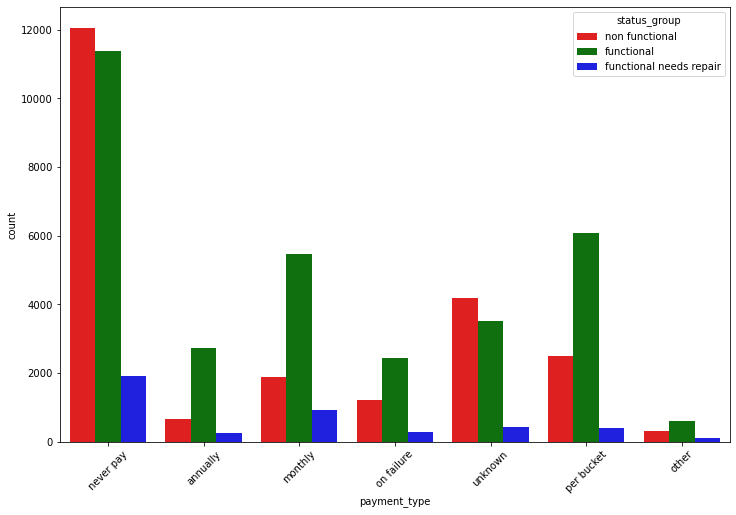

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='payment_type', hue='status_group', data=df, ax=ax, palette=color_status)
plt.xticks(rotation=45)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

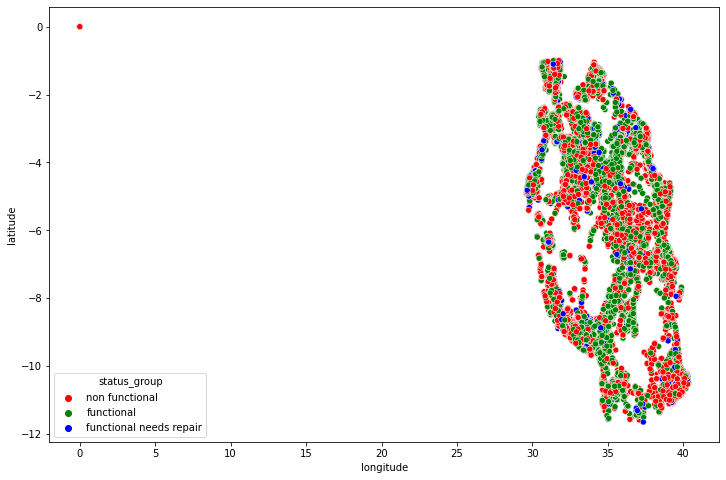

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude', data=df, hue='status_group', ax=ax, palette=color_status)